# Dual blocker therapy (DBT) plasma proteome Paper — Figure 2

This Jupyter Notebook (with Python 3 kernel) contained the code for the proteomic analysis of proteome and clinical indicators among healthy control, pre DBT and 1st DBT.

Input files:  
* The clinical file: category.csv, continuous.csv
* The DBT proteome file: dbt.csv
* The DBT proteome-based ssGSEA score: ssgsea.csv

Output figures:  
* Figure 2A-D, S3A, S3B

In [2]:
from utils import *
paths = ['../figure/figure2', '../documents/figure2']
for path in paths:
    if not os.path.isdir(path):
        os.makedirs(path)

a = Analysis('../')

gmt_path = '../documents/database.gmt'
gmt = pd.read_table(gmt_path, index_col=0, header=None).drop(1, axis=1).stack().droplevel(1)

### Different expressed protein table among healthy control, pre DBT, and 1st DBT groups

In [3]:
a.set_param('group', dataset_type='dbt', group_name='Therapy ID', part_element=['Healthy control', 'pre DBT', '1st DBT'], file_type='category', thresh=.7)
table = a.table.query("kruskal_fdr<.05").rename(columns=lambda x: x.replace('_mean', ''))
data = a.merge_data_group(a.table.index)
table = pd.concat([data.apply(scipy.stats.zscore, nan_policy='omit').groupby('Therapy ID').mean().T, a.table.iloc[:, 3:]], axis=1)
table = table.assign(healthy_control_vs_pre_DBT_group=table['Healthy control']-table['pre DBT'], first_DBT_vs_pre_DBT_group=table['1st DBT']-table['pre DBT'])

signs = ['>>', '<<', '<>', '><']
labels = ['HLH', 'LHL', 'LMH', 'HML']
for sign, label in zip(signs, labels):
    query_condition = "healthy_control_vs_pre_DBT_group{}0&first_DBT_vs_pre_DBT_group{}0".format(sign[0], sign[1])
    table.loc[table.query(query_condition).index, 'label'] = label
table = table.rename(columns=lambda x: x.replace('first', '1st')).iloc[:, [0, 1, 2, 8, -4 ,-3, -2, -1]]

hpa = pd.read_csv('../documents/HPA_annotation.csv')
hpa = hpa.drop_duplicates().set_index('Gene Symbol')
table = pd.merge(table, hpa['organ'].rename('HPA specific annotation'), left_index=True, right_index=True, how='left').rename_axis('Genes')

table.to_csv('../documents/figure2/healthy_control-pre_DBT-1st_DBT_proteome_comparison_table.csv')

### ORA of protein class (HLH, LHL, LMH)

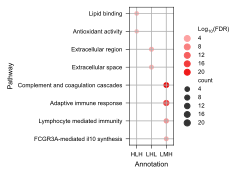

In [4]:
from utils.statistic import fdr

o = ora(tool='gprofiler')
enrichment = table.query('kruskal_fdr<0.05').reset_index().groupby('label')['Genes'].apply(lambda x: o.run(x.values.tolist())).groupby('label').apply(lambda x: x.assign(fdr=fdr(x['p_value'])[1]))
enrichment.to_csv('../documents/figure2/protein_clusters_ORA_table.csv')

import matplotlib.colors as mcolors
colormap = mcolors.LinearSegmentedColormap.from_list("", ['#FFB8B8', '#ED0000'], N=256)

terms = {'HLH': ['lipid binding', 'antioxidant activity'], 'LHL': ['extracellular region', 'extracellular space'], 'LMH': ['Complement and coagulation cascades', 'lymphocyte mediated immunity', 'adaptive immune response', 'FCGR3A-mediated IL10 synthesis']}
df = pd.DataFrame()
for label, term in terms.items():
    df = pd.concat([df, enrichment.loc[[label]].query("name in @term")], axis=0)
plotdata = df.query("source!='WP'").loc[:, ['name', 'fdr', 'intersections']].droplevel(1).reset_index().rename(columns={'label': 'Annotation', 'name': 'Pathway'})
plotdata['$\mathregular{Log_{10}}$(FDR)'] = -np.log10(plotdata['fdr'])
plotdata['count'] = plotdata['intersections'].apply(lambda x: len(x))
plotdata['Pathway'] = plotdata['Pathway'].str.capitalize().str.replace('Il10', 'IL10').str.replace('Fcgr3a', 'FCGR3A')

ax = bubbleplot(plotdata.iloc[:, [0, 1, -2, -1]], palette=colormap, figsize=(.8, 2.5), sizes=(20, 40), ticklabels_wrap=False)
ax.set_xlim([-.5, 2.5])
ax.grid()
ax.get_figure().savefig('../figure/figure2/Fig2B_ORA_bubbleplot.pdf', bbox_inches='tight')

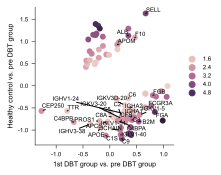

In [5]:
highlight_points = np.unique(np.hstack(df.query("name in ['lipid binding', 'extracellular region', 'adaptive immune response']")['intersections'].values)).tolist()
plotdata = table.query('kruskal_fdr<.05').iloc[:, [3, 5, 6]]
plotdata['$\mathregular{Log_{10}}$(FDR)'] = -np.log10(plotdata['kruskal_fdr'])
ax = scatterplot(plotdata.iloc[:, [2, -1, 1]], ticklabels_format=[], ticklabels_hide=[], highlight_points=highlight_points, figsize=(2.5, 2.5))
ax.set_xlabel('1st DBT group vs. pre DBT group')
ax.set_ylabel('Healthy control vs. pre DBT group')
ax.get_figure().savefig('../figure/figure2/Fig2A_healthy-control_before-DBT_1st-DBT_proteome_comparison_scatterplot.pdf', bbox_inches='tight')

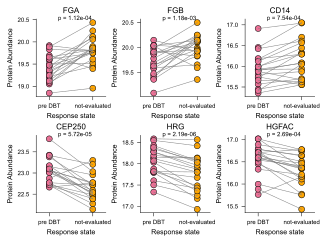

In [6]:
from utils.statistic import fdr
a.set_param('group', dataset_type='dbt', group_name='Therapy ID', part_element=['pre DBT', '1st DBT'], ttest_kwargs={})
data = a.merge_data_group(a.dbt.index, group_name=['Therapy ID', 'Patient ID'])
data = data[data.index.get_level_values(2).duplicated(keep=False)].sort_index(level=2)
pre_DBT = data.xs('pre DBT', axis=0, level=1)
first_DBT = data.xs('1st DBT', axis=0, level=1)
statistic, pvalues = scipy.stats.ttest_rel(pre_DBT, first_DBT, nan_policy='omit')
pairwise_table = a.table.iloc[:, :6].assign(ttest_statistics=statistic, ttest_pvalues=pvalues)
pairwise_table = pairwise_table.assign(ttest_fdr=fdr(pairwise_table['ttest_pvalues'])[1])

fig, axs = plt.subplots(2, 3, figsize=(5, 3.5))
plt.subplots_adjust(wspace=.5, hspace=.5)

for ax, term in zip(axs.ravel(), ['FGA', 'FGB', 'CD14', 'CEP250', 'HRG', 'HGFAC']):
    tmp = a.category.loc[a.category['Therapy ID'].isin(['pre DBT', '1st DBT']), ['Patient ID', 'Response state iRECIST']]
    tmp = pd.concat([tmp, a.dbt.loc[term]], axis=1).dropna()
    data = tmp[tmp['Patient ID'].duplicated(keep=False)]
    lineplot(data.iloc[:, [1, 0, 2]], palette=['gray']*(int(len(data)/2)), figsize=(2, 2), ticklabels_format=[], ticklabels_hide=[], ax=ax)
    scatterplot(data.drop('Patient ID', axis=1).assign(hue=data['Response state iRECIST']).iloc[:, [0, -1, 1]], ax=ax, ticklabels_format=[], ticklabels_hide=[], palette=['#ed7096', 'orange'], edgecolor='black', linewidth=.5)

    p = pairwise_table.loc[term, 'ttest_pvalues']
    ax.set_xlim([-.3, 1.3])
    ax.get_legend().remove()
    ax.set_title(term)
    ax.text(x=0.2, y=ax.get_ylim()[1]-.02, s='p = {:.2e}'.format(p), fontsize=6)
    ax.set_xlabel('Response state')
    ax.set_ylabel('Protein Abundance')
fig.savefig('../figure/figure2/Fig2C_Inflammation_cell-cycle_metastasis_protein_pairwise_pre-DBT_1st-DP_plot.pdf', bbox_inches='tight')

### Organ enrichment and plotting

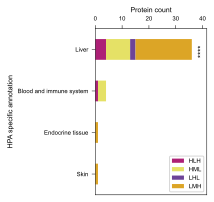

In [7]:
from utils.eplot.base import prob_star

cross_table = pd.crosstab(table['label'], table['HPA specific annotation'])
organs_list = table.query("kruskal_fdr<.05").sort_values('kruskal_fdr')['HPA specific annotation'].dropna().unique().tolist()
real = table['HPA specific annotation'].value_counts().loc[organs_list].values
target = hpa['organ'].value_counts().loc[organs_list]
target = real.sum() * target / target.sum()
chisquare_statistic, chisquare_pvalue = scipy.stats.chisquare(real, target)

palette = dict(zip(['HLH', 'LHL', 'LMH', 'HML'], ['#AD2076', '#6D4397', '#DCA526', '#E5E166']))
plotdata = table.query("kruskal_fdr<.05").groupby(['HPA specific annotation', 'label']).count().iloc[:, 0].rename('Protein count')
ax = plotdata.unstack().loc[organs_list].iloc[::-1].plot.barh(stacked=True, figsize=(2, 3), color=palette)
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1]*1.1)
ax.text(ax.get_xlim()[1]*.92, len(organs_list)-1.17, prob_star(chisquare_pvalue), rotation=90, fontsize=8)
ax.legend(loc='lower right')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel('Protein count')
ax.get_figure().savefig('../figure/figure2/Fig2D_HPA_tissue_specific_annotation_barplot.pdf', bbox_inches='tight')

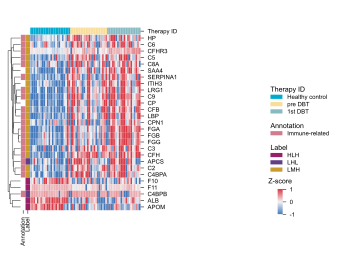

In [8]:
a.set_param('group', dataset_type='dbt', group_name='Therapy ID', part_element=['Healthy control', 'pre DBT', '1st DBT'])
gene = table[(table['HPA specific annotation']=='Liver')&(table['kruskal_fdr']<0.05)&(table['label']!='HML')].index
immune_related_gene = gmt[gmt.isin(gene)].filter(like='IMMUNE', axis=0).unique()
annot_dict = {'Annotation': dict(zip(immune_related_gene, ['Immune-related']*len(immune_related_gene))), 'Label': table[(table['HPA specific annotation']=='Liver')&(table['kruskal_fdr']<0.05)]['label'].to_dict()}

fig = a.heat(gene, annot_dict=annot_dict, row_cluster=True, sort='no', lut={'Annotation': {'Immune-related': '#D07C8C'}, 'Label': {'HLH': '#982069', 'LHL': '#623E85', 'LMH': '#CB9B2E'}}, cbar_pos=(1.1, .15, .02, .1), dendrogram_ratio=.1, figsize=(3.5, 3.5), colors_ratio=.035)
ax = fig.ax_heatmap
ax.set_yticklabels([item.get_text().split('-')[0] for item in ax.get_yticklabels()])
fig.ax_cbar.set_title('Z-score', fontsize=7)
fig.savefig('../figure/figure2/FigS3A_Liver_specific_proteins_heatmap.pdf', bbox_inches='tight')

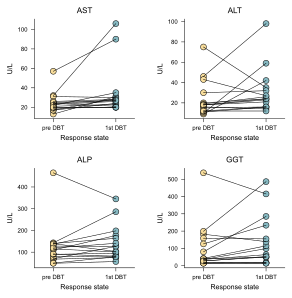

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(4.5, 4.5))
plt.subplots_adjust(wspace=.5, hspace=.5)

for ax, term in zip(axs.ravel(), ['AST', 'ALT', 'ALP', 'GGT']):
    tmp = a.category.loc[a.category['Therapy ID'].isin(['pre DBT', '1st DBT']), ['Patient ID', 'Therapy ID']]
    tmp = pd.concat([tmp, a.continuous.loc[term]], axis=1).dropna()
    data = tmp[tmp['Patient ID'].duplicated(keep=False)]
    lineplot(data.iloc[:, [1, 0, 2]], palette=['black']*(int(len(data)/2)), figsize=(2, 2), ticklabels_format=[], ticklabels_hide=[], ax=ax)
    scatterplot(data.drop('Patient ID', axis=1).assign(hue=data['Therapy ID']).iloc[:, [0, -1, 1]], ax=ax, ticklabels_format=[], ticklabels_hide=[], palette=a._color_map['Therapy ID'], edgecolor='black', linewidth=.5)

    group = data.groupby('Therapy ID', sort=False)[term]
    ax.set_xlim([-.3, 1.3])
    ax.get_legend().remove()
    ax.set_title(term)
    ax.set_xlabel('Response state')
    ax.set_ylabel('U/L')

fig.savefig('../figure/figure2/FigS3B_liver_clinical-indicators_pairwise_cateplot.pdf', bbox_inches='tight')